In [1]:
#%pip install datasets
import ast
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#getdata
dataset=load_dataset('lukebarousse/data_jobs')
df=dataset['train'].to_pandas()
#cleandata
df['job_posted_date']=pd.to_datetime(df['job_posted_date'])
df['job_skills']=df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

d:\python\libs\miniconda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#get only data engineering jobs in US
df_DE_US=df[(df['job_title_short']=="Data Engineer") & (df['job_country']=='United States')].copy()

#drop nan values from 'salary_year_avg' col.
df_DE_US = df_DE_US.dropna(subset=['salary_year_avg'])

In [3]:
#convert the job_posted_date to month new col
df_DE_US['job_posted_month_no']=df_DE_US['job_posted_date'].dt.month

#groupby by month number so its 1-12
DE_job_totals = df_DE_US.groupby('job_posted_month_no').size()

In [4]:
#explode out all the job skills
df_DE_US_exploded=df_DE_US.explode('job_skills')

#add exploded job skills and add an index with the months in it
DE_US_pivot=df_DE_US_exploded.pivot_table(index='job_posted_month_no', columns='job_skills', aggfunc='size', fill_value=0)



#create new row total with sum of the total job skills 
DE_US_pivot.loc['Total']=DE_US_pivot.sum()

#sort by the new row
DE_US_pivot=DE_US_pivot[DE_US_pivot.loc['Total'].sort_values(ascending=False).index]




#drop total row we just made
DE_US_pivot = DE_US_pivot.drop('Total')

#with pd.div divide the dataframe of job skills by the column with the number of jobs in every month
DE_US_percent=DE_US_pivot.div(DE_job_totals, axis=0)*100

In [5]:
#I just copy and pasted this and adjusted to my dataset this is to format the months into actual month names
DE_US_percent =DE_US_percent.reset_index()
DE_US_percent['job_posted_month'] = DE_US_percent['job_posted_month_no'].apply(lambda x: pd.to_datetime(x, format='%m').strftime('%b'))
DE_US_percent= DE_US_percent.set_index('job_posted_month')
DE_US_percent = DE_US_percent.drop(columns='job_posted_month_no')

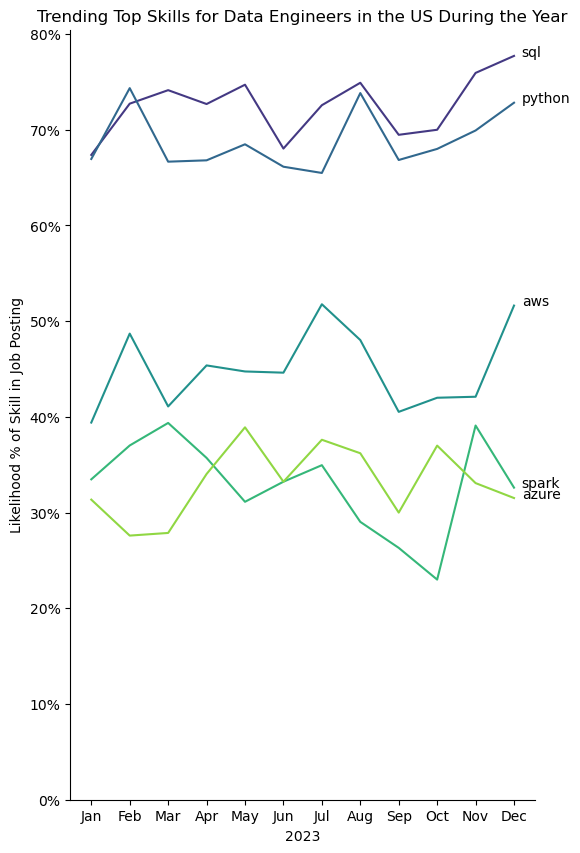

In [8]:
#get only first/biggest 5 values of the jobskills/No.ofpostingseverymonth dataframe
DE_US_plot=DE_US_percent.iloc[:, :5]
fig, ax = plt.subplots(figsize=(6,10))
sns.lineplot(data=DE_US_plot, dashes=False, palette="viridis", ax=ax)

#alot of formatting, like wow
sns.despine()
plt.title("Trending Top Skills for Data Engineers in the US During the Year")
plt.ylabel('Likelihood % of Skill in Job Posting')
plt.xlabel('2023')
plt.legend().remove()
ax.set_ylim(bottom=0)

#more formatting (i did this by following the course)
from matplotlib.ticker import PercentFormatter
ax.yaxis.set_major_formatter(PercentFormatter(decimals=0))
for i in range(5):
    plt.text(11.2, DE_US_plot.iloc[-1,i], DE_US_plot.columns[i])

plt.show()